## Assignment 1 Euler-Bernoulli's beam

In [2]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

x, L, q0, P, E, I = symbols('x L q0 P E I')

w1 = Function('w1')(x) # w is a function of x

diffeq1 = Eq(E*I * diff(w1, x, 4), q0)

w1_expression = dsolve(diffeq1, w1).rhs

M = -E*I*w1_expression.diff(x, 2)

C1, C2, C3, C4 = symbols('C1 C2 C3 C4')

# Boundary conditions for distributed load
boundary_conditions1 = [ w1_expression.subs(x, 0), 0,               #w(0) = 0
                        w1_expression.diff(x).subs(x, 0),           #w'(0) = 0
                        M.subs(x, L), 0,                            #w''(L) = 0
                        w1_expression.diff(x,3).subs(x, L), 0]      #w'''(L) = 0

integration_constants = solve(boundary_conditions1, C1, C2, C3, C4, real=True)

display(integration_constants)

solution1 = w1_expression.subs(integration_constants)

display(simplify(solution1))




w2 = Function('w2')(x) # w is a function of x

diffeq2 = Eq(E*I * diff(w2, x, 4), 0)

w2_expression = dsolve(diffeq2, w2).rhs

M = -E*I*w2_expression.diff(x, 2)

D1, D2, D3, D4 = symbols('D1 D2 D3 D4')

# Boundary conditions for point load at the free end
boundary_conditions2 = [
    Eq(w2_expression.subs(x, 0), 0),                      # w(0) = 0
    Eq(w2_expression.diff(x).subs(x, 0), 0),              # w'(0) = 0
    Eq(w2_expression.diff(x,2).subs(x, L), 0),            # w''(L) = 0 (no bending moment)
    Eq(w2_expression.diff(x,3).subs(x, L), -P/(E*I))      # w'''(L) = -P/(EI)
]



integration_constants2 = solve(boundary_conditions2, [D1, D2, D3, D4], dict=True)[0]

display(boundary_conditions2)

solution2 = w2_expression.subs(integration_constants2)

display(simplify(solution2))

# Funkade ej, undersök varför



{C1: 0, C2: 0, C3: L**2*q0/(4*E*I), C4: -L*q0/(6*E*I)}

q0*x**2*(6*L**2 - 4*L*x + x**2)/(24*E*I)

IndexError: list index out of range

{C1: 0, C2: 0, C3: L**2*q0/(4*E*I), C4: -L*q0/(6*E*I)}

q0*x**2*(6*L**2 - 4*L*x + x**2)/(24*E*I)

Solutions found: [{D1: 0, D2: 0, D3: L*P/(2*E*I), D4: -P/(6*E*I)}]


P*x**2*(3*L - x)/(6*E*I)

(E*I*q0*x**2*(6*L**2 - 4*L*x + x**2) + 4*E*I*P*x**2*(3*L - x))/(24*E*E*I*I)

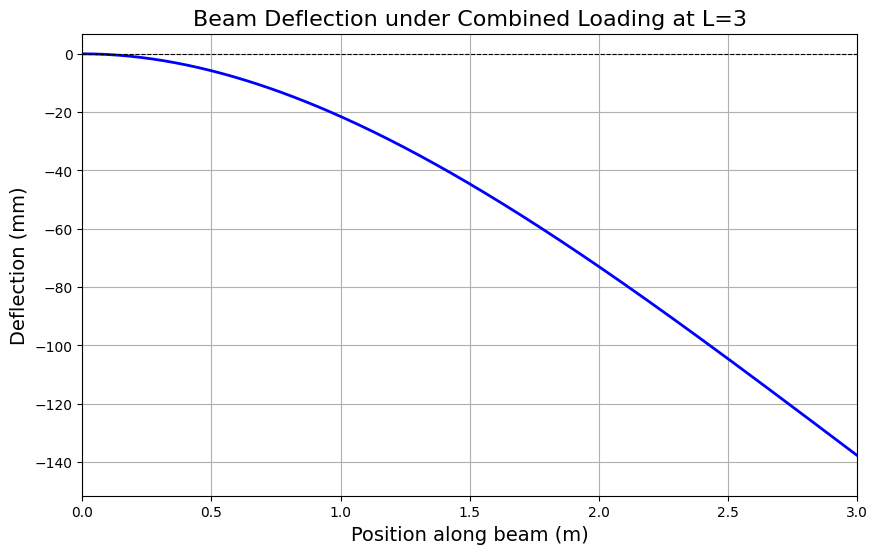

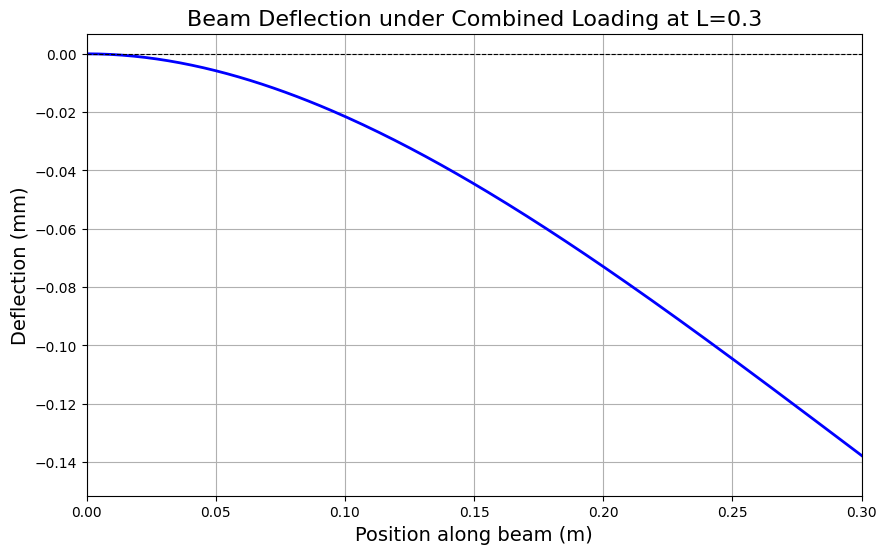

In [4]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

x, L, q0, P, E, I = symbols('x L q0 P E I')

w1 = Function('w1')(x) # w is a function of x

diffeq1 = Eq(E*I * diff(w1, x, 4), q0)

w1_expression = dsolve(diffeq1, w1).rhs

M = -E*I*w1_expression.diff(x, 2)

C1, C2, C3, C4 = symbols('C1 C2 C3 C4')

# Boundary conditions for distributed load
boundary_conditions1 = [ w1_expression.subs(x, 0), 0,               #w(0) = 0
                        w1_expression.diff(x).subs(x, 0),           #w'(0) = 0
                        M.subs(x, L), 0,                            #w''(L) = 0
                        w1_expression.diff(x,3).subs(x, L), 0]      #w'''(L) = 0

integration_constants = solve(boundary_conditions1, C1, C2, C3, C4, real=True)

display(integration_constants)

solution1 = w1_expression.subs(integration_constants)

display(simplify(solution1))

from sympy import *

# --- Define symbols ---
x, L, P, E, I = symbols('x L P E I', real=True)
D1, D2, D3, D4 = symbols('D1 D2 D3 D4', real=True)

# --- Define the general homogeneous solution manually ---
w2_general = D1 + D2*x + D3*x**2 + D4*x**3   # EI*w'''' = 0 → cubic polynomial

# --- Define bending moment and derivatives ---
M = -E*I*diff(w2_general, x, 2)

# --- Boundary conditions ---
bc_eqs = [
    Eq(w2_general.subs(x, 0), 0),                # w(0) = 0
    Eq(diff(w2_general, x).subs(x, 0), 0),       # w'(0) = 0
    Eq(diff(w2_general, x, 2).subs(x, L), 0),    # w''(L) = 0
    Eq(diff(w2_general, x, 3).subs(x, L), -P/(E*I))  # w'''(L) = -P/(EI)
]

# --- Solve for constants ---
integration_constants = solve(bc_eqs, [D1, D2, D3, D4], dict=True)
print("Solutions found:", integration_constants)

# Pick first solution (Sympy returns a list of dicts)
constants = integration_constants[0]

# --- Substitute constants into w2(x) ---
w2_solution = simplify(w2_general.subs(constants))

display(w2_solution)



solution_total = simplify(solution1 + w2_solution)
display(solution_total)

w_func = lambdify((x, L, q0, P, E, I), solution_total, 'numpy')

# Numerical values
L1 = 3; L2 = 0.3

L=L1
E=220e9
b=h=0.05
I = b*h**3/12; #moment of inertia
rho = 7800; #density
g = 9.81
m = 130
P = -m*g
poisson = 0.3
q0 = -((m*g)/L)

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()


# Numerical values
L1 = 3; L2 = 0.3

L=L2
q0 = -((m*g)/L2)

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=0.3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()

## Timoshenko beam theory

L*P*x**2/(2*E*I) - P*x**3/(6*E*I)

L**2*q0*x**2/(4*E*I) - L*q0*x**3/(6*E*I) + q0*x**4/(24*E*I) - q0*x**2/(2*A*G*Ks)

x**2*(A*G*Ks*(6*L**2*q0 + 12*L*P - 4*L*q0*x - 4*P*x + q0*x**2) - 12*E*I*q0)/(24*A*E*G*I*Ks)

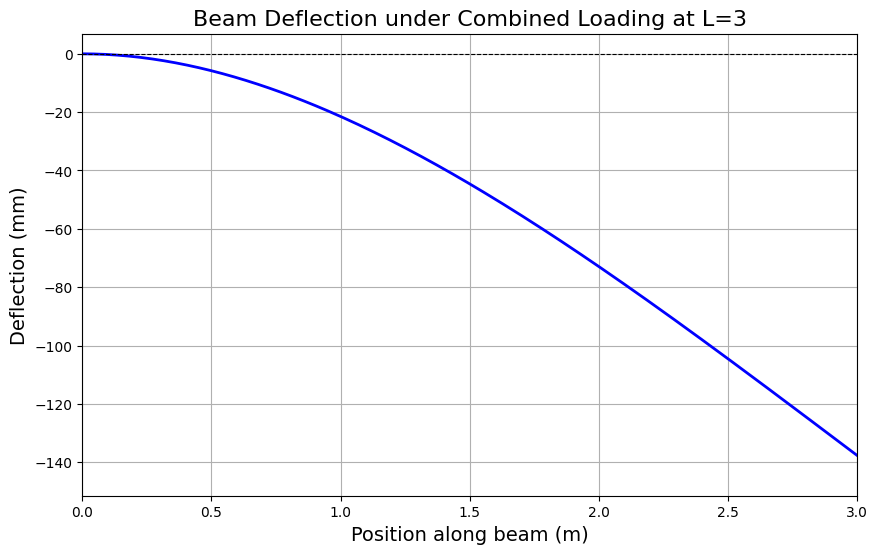

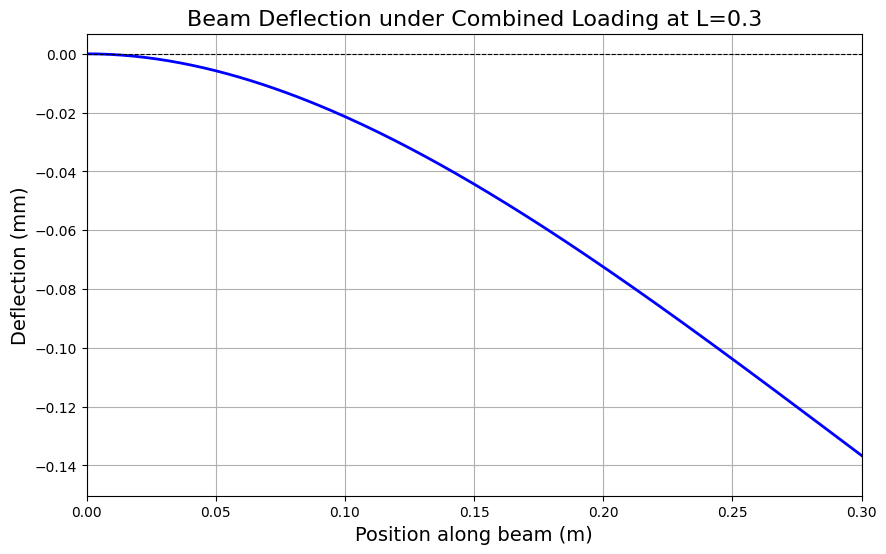

In [5]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

#############
# Poiint load

x, q0, E, I, Ks, G, A, L, P = symbols('x q0 E I Ks G A L P', real=True)

f_phi = Function('phi') # phi is a function of x

## Define the differential equation in terms of phi
diffeq_phi = Eq(E*I*f_phi(x).diff(x, 3), 0)

## Solve the differential equation for phi(x) (eq. 3.35 LN)
phi = dsolve(diffeq_phi, f_phi(x)).rhs

## Solve the differential equation for w(x) (eq. 3.36 LN)
w = Function('w') # w is a function of x
diffeq_w = Eq(w(x).diff(x), -E*I/(G*Ks*A)*phi.diff(x,2) + phi)
w        = dsolve(diffeq_w, w(x)).rhs

## Define boundary conditions
M = -E*I*phi.diff(x)
bc_eqs = [
    Eq(w.subs(x, 0), 0),                # w(0) = 0
    Eq(diff(w, x).subs(x, 0), 0),       # w'(0) = 0
    Eq(diff(w, x, 2).subs(x, L), 0),    # w''(L) = 0
    Eq(diff(w, x, 3).subs(x, L), -P/(E*I))  # w'''(L) = -P/(EI)
]

## Solve for the integration constants
integration_constants = solve(bc_eqs, 'C1, C2, C3, C4', real=True)

## Substitute the integration constants into the solution
solution1 = w.subs(integration_constants)

display(solution1)



##################
# Distributed load

## Define symbolic variables
x, q0, E, I, Ks, G, A, L = symbols('x q0 E I Ks G A L', real=True)

f_phi = Function('phi') # phi is a function of x

## Define the differential equation in terms of phi
diffeq_phi = Eq(E*I*f_phi(x).diff(x, 3), q0)

## Solve the differential equation for phi(x) (eq. 3.35 LN)
phi = dsolve(diffeq_phi, f_phi(x)).rhs

## Solve the differential equation for w(x) (eq. 3.36 LN)
w = Function('w') # w is a function of x
diffeq_w = Eq(w(x).diff(x), -E*I/(G*Ks*A)*phi.diff(x,2) + phi)
w        = dsolve(diffeq_w, w(x)).rhs

## Define boundary conditions
M = -E*I*phi.diff(x)
boundary_conditions1 = [ w.subs(x, 0), 0,               #w(0) = 0
                        w.diff(x).subs(x, 0),           #w'(0) = 0
                        M.subs(x, L), 0,                #w''(L) = 0
                        w.diff(x,3).subs(x, L), 0]      #w'''(L) = 0

## Solve for the integration constants
integration_constants = solve(boundary_conditions1, 'C1, C2, C3, C4', real=True)

## Substitute the integration constants into the solution
solution2 = w.subs(integration_constants)

solution2

display(solution2)

solution_total = solution1 + solution2

display(simplify(solution_total))


w_func = lambdify((x, L, q0, P, E, I, Ks, A, G), solution_total, 'numpy')

# Numerical values
L1 = 3; L2 = 0.3

L=L1
E=220e9
b=h=0.05
I = b*h**3/12; #moment of inertia
rho = 7800; #density
g = 9.81
m = 130
P = -m*g
poisson = 0.3
q0 = -((m*g)/L)
Ks = 5/6
A = b*h
G = E/(2*(1+poisson))    

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I, A, G, Ks)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()


# Numerical values
L1 = 3; L2 = 0.3

L=L2
q0 = -((m*g)/L2)

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I, A, G, Ks)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=0.3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()